### current goal

see which loss function is better: 

arguments:

- masked loss directly optmized what is important
- normal one can stabalize the response of nodes before getting born

In [1]:
!nvidia-smi

Tue Oct 27 19:49:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:19:00.0 Off |                  Off |
| 33%   44C    P8    33W / 260W |  45859MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import torch.nn as nn
import datetime
import time
%matplotlib inline
from IPython.core.debugger import set_trace
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, LeakyReLU, LayerNorm
from torch_geometric.nn import GCNConv, SplineConv, NNConv, DeepGCNLayer, GENConv
import pyvista as pv
from threading import Thread
import vtk
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
np.random.seed(0)
torch.manual_seed(0)
pv.set_plot_theme("document")
sns.set(color_codes=True, font_scale=1)

In [4]:
def load_simulation_input(simulation_id, simulation_result_path = '/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results'):
    edge_index_list = []
    pos_list = []
    elements = []
    birth_list_element = []
    birth_list_node = []
    with open('{}/{}/gamma/{}.k'.format(simulation_result_path, simulation_id, simulation_id)) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*NODE':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        node_base = int(text[0])
                        first = False
                    pos_list.append([float(text[1]),float(text[2]),float(text[3])])
            if line.split()[0] == '*END':
                break  
    birth_list_node = [-1 for _ in range(len(pos_list))]
    with open('{}/{}/gamma/{}.k'.format(simulation_result_path, simulation_id, simulation_id)) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*ELEMENT_SOLID':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        element_base = int(text[0])
                        first = False
                    elements.append([int(text[2])-node_base, int(text[3])-node_base, int(text[4])-node_base, int(text[5])-node_base,
                                     int(text[6])-node_base, int(text[7])-node_base, int(text[8])-node_base, int(text[9])-node_base])
                    for source_ind in range(2, 10):
                        for taget_ind in range(2, 10):
                            if source_ind == taget_ind:
                                continue
                            edge_index_list.append([int(text[source_ind])-node_base, int(text[taget_ind])-node_base])
            if line.split()[0] == '*END':
                break
    birth_list_element = [-1.0]*len(elements)
    with open('{}/{}/gamma/{}.k'.format(simulation_result_path, simulation_id, simulation_id)) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*DEFINE_CURVE':
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    birth_list_element[int(float(text[1]))-element_base] = float(text[0])
            if line.split()[0] == '*END':
                break     
    
    for element, birth_element in zip(elements, birth_list_element):
        if birth_element < 0:
            continue
        for node in element:
            if (birth_list_node[node] > birth_element or 
                                        birth_list_node[node] < 0):
                                    birth_list_node[node] = birth_element

    edge_index = torch.tensor(edge_index_list ,dtype=torch.long)
    elements = torch.tensor(elements ,dtype=torch.long)
    pos = torch.tensor(pos_list ,dtype=torch.float)
    birth_element = torch.tensor(birth_list_element, dtype=torch.float)
    birth_node = torch.tensor(birth_list_node, dtype=torch.float)
    return edge_index, elements, pos, birth_element, birth_node

def load_toolpath(simulation_id, simulation_result_path = '/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results', dt = 0.1):
    file = '{}/{}/gamma/toolpath.crs'.format(simulation_result_path, simulation_id)
    toolpath_raw=pd.read_table(file, delimiter=r"\s+",header=None, names=['time','x','y','z','state'])
    toolpath=[]
    state=[]
    time=0.0
    ind=0
    endTime = float(toolpath_raw.tail(1)['time'])
    while(time<=endTime):
        while(time>=toolpath_raw['time'][ind+1]):
            ind=ind+1
        X=toolpath_raw['x'][ind]+(toolpath_raw['x'][ind+1]-toolpath_raw['x'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Y=toolpath_raw['y'][ind]+(toolpath_raw['y'][ind+1]-toolpath_raw['y'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Z=toolpath_raw['z'][ind]+(toolpath_raw['z'][ind+1]-toolpath_raw['z'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        toolpath.append([X,Y,Z])
        state.append(toolpath_raw['state'][ind+1])
        time = time +dt
    return toolpath, state, endTime

def load_simulation_output(simulation_id, simulation_result_path = '/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results'):
    temperature = pd.read_csv('{}/{}/gamma/{}.csv'.format(simulation_result_path, simulation_id, simulation_id))
    temperature.drop(temperature.columns[len(temperature.columns)-1], axis=1, inplace=True)
    return torch.tensor(temperature.values, dtype=torch.float)

In [5]:
class AdditiveThermalDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, normalize=True):
        self.seq_len = 100 # length of each sample
        self.sample_per_simulation = 100 # number of samples in each simulation
        self.simulation_ids = [x.stem for x in Path('/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results').iterdir() if x.is_dir()]
        self.normalize = normalize
        if normalize:
            self.stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
        super(AdditiveThermalDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['am_graph.simul0.data0']

    def download(self):
        pass
    
    def process(self):
        
        i = 0 # simulation_idx
        for simulation_id in self.simulation_ids:
            print("processing simulation {}!".format(simulation_id))
            j = 0 # time_idx
        
            # load simulation settings
            edge_index, elements, pos, birth_element, birth = load_simulation_input(simulation_id)
            toolpath, state, endTime = load_toolpath(simulation_id)
            
            # temperature output
            temperature = load_simulation_output(simulation_id)
            temperature = torch.clamp(temperature, 300.0, 2000.0)

            # edge feature (length of each edge)
            edge_pos = pos[edge_index.long()]
            edge_dis = ((edge_pos[:, 0, :] - edge_pos[:, 1, :])**2).sum(dim = 1)
            
            # boundary feature (distance to fixed boundary condition at z = -20)
            boundary = pos[:, 2] + 20.0

            assert (temperature.shape[1] == pos.shape[0])

            seed = np.random.permutation(temperature.shape[0]-self.seq_len)[0:self.sample_per_simulation] # the starting time of each sample 
            torch.save(seed, osp.join(self.processed_dir, 'simul{}.seed'.format(i)))
            j = 0
            for start_time in seed:
                x_data = torch.Tensor([])
                y_data = torch.Tensor([])
                birth_data = torch.Tensor([])
                for time_step in range(start_time, start_time + self.seq_len):
                    toolpath_current_step = toolpath[time_step]
                    state_current_step = state[time_step]   
                    r2 = (pos[:, 0] - toolpath_current_step[0])**2 + (pos[:, 1] - toolpath_current_step[1])**2 + (pos[:, 2] - toolpath_current_step[2])**2 + 0.1
                    if state_current_step == 1:
                        laser_feature = 1/r2
                    else:
                        laser_feature = r2 * 0.0                   

                    temp_time_step = temperature[time_step, :]
                    # temp_time_step_next = temperature[time_step + 1, :]

                    birth_time_step = (birth < time_step * 0.1).float()
                    # birth_time_step_next = (birth < (time_step + 1) * 0.1).float()

                    birth_time_element = (birth_element < time_step * 0.1).float()

                    x = torch.cat([
                    #              temp_time_step.unsqueeze(1),
                                   birth_time_step.unsqueeze(1),
                                   boundary.unsqueeze(1),
                                   laser_feature.unsqueeze(1)], dim = 1)
                    y = torch.cat([temp_time_step.unsqueeze(1),
                    #              temp_time_step_next.unsqueeze(1),
                    #              birth_time_step_next.unsqueeze(1)
                                  ], dim = 1)

                    x_data = torch.cat((x_data, x.unsqueeze(0)),0)
                    y_data = torch.cat((y_data, y.unsqueeze(0)),0)
                    birth_data = torch.cat((birth_data, birth_time_element.unsqueeze(0)),0)

                data = Data(x=x_data, y=y_data, birth_element=birth_data)
                torch.save(data, osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))

                j = j + 1
                if j%40 == 0:
                    print("{:.2f} %".format(j/2))

            const_data = Data(pos = pos, edge_index=edge_index.t().contiguous(), edge_attr = edge_dis, elements=elements)
            torch.save(const_data, osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
            i += 1
            
    def len(self):
        return self.sample_per_simulation * len(self.simulation_ids) * (self.seq_len-1)

    def get(self, idx):
        i = idx//(self.sample_per_simulation * (self.seq_len-1))
        j = (idx%(self.sample_per_simulation * (self.seq_len-1)))//(self.seq_len-1)
        k = (idx%(self.sample_per_simulation * (self.seq_len-1)))%(self.seq_len-1)
        constant_data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
        data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))
        smoothed = self.smooth(data['y'], base_temp = 5000)
        smoothed_laser = self.smooth(data['x'][:,:, 2:].clamp(0, 1.0), base_temp = 0.35)
        data_x = data['x'][k, :, :2]
        data_x_p1 = data['x'][k + 1, :, :]
        data_e = constant_data['edge_attr']
        data_xt = smoothed[k, :, :]
        data_y = smoothed[k + 1, :, :]
        data_xl = smoothed_laser[k, :, :]
        if self.normalize:
            # normalize boundary feature to the range of 0-1
            data_x[:,1] = (data_x[:,1] - self.stats[1,2]) / (self.stats[1,3] - self.stats[1,2])
            # nomalize edge feature to mean of zero and std of 1
            data_e = 1.0/data_e**0.5
            # normalize temperature
            data_xt = (data_xt - 300) / 4700
            data_y = (data_y - 300) / 4700
            
        return Data(
#                     x=torch.cat((data_xt, data_x), 1), 
                    x=torch.cat((data_xt, data_x, data_xl,  data_x_p1[:,:1]), 1), 
                    y=data_y, 
                    pos=constant_data['pos'], 
                    edge_index=constant_data['edge_index'],
                    edge_attr = data_e,
                    birth_element=data['birth_element'][k + 1,:],
                    elements=constant_data['elements']
                   )
    
    def smooth(self, data, base_temp = 5000):
        added = (data - base_temp).clamp(min = 0) / 10
        final = data.clamp(max = base_temp) + added
        return final

In [6]:
dataset = AdditiveThermalDataset('/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling', normalize=True)

In [7]:
len(dataset)

445500

In [8]:
# main database
test_simulations = 5
train_samples = 10000
test_start_index = (len(dataset.simulation_ids) - test_simulations)* dataset.sample_per_simulation * (dataset.seq_len-1)
train_dataset = dataset[:test_start_index]
train_dataset = train_dataset.shuffle()
train_dataset = train_dataset[:train_samples]
test_dataset = dataset[test_start_index:]
len(train_dataset), len(test_dataset)

(10000, 49500)

In [8]:
# # small database for debugging
# test_simulations = 5
# train_samples = 1000
# test_samples = 200
# test_start_index = (len(dataset.simulation_ids) - test_simulations)* dataset.sample_per_simulation * (dataset.seq_len-1)
# train_dataset = dataset[:test_start_index]
# train_dataset = train_dataset.shuffle()
# train_dataset = train_dataset[:train_samples]
# test_dataset = dataset[test_start_index:]
# test_dataset = test_dataset.shuffle()
# test_dataset = test_dataset[:test_samples]
# len(train_dataset), len(test_dataset)

(1000, 200)

In [9]:
dataset[0]

Data(birth_element=[19761], edge_attr=[1106616], edge_index=[2, 1106616], elements=[19761, 8], pos=[23636, 3], x=[23636, 5], y=[23636, 1])

In [10]:
batch_size= 1
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size)
visualization_loader = DataLoader(train_dataset, batch_size=1)

In [11]:
# # only run for the first time when building the stats, other times stats can be just loaded from AdditiveThermalDataset

# sums, squared_sums, num_sample, min_, max_ = torch.zeros(4), torch.zeros(4), torch.zeros(4), torch.ones(4) * 1e10, torch.ones(4) * -1e10
# sums_e, squared_sums_e, num_sample_e, min_e, max_e = torch.zeros(1), torch.zeros(1), torch.zeros(1), torch.ones(1) * 1e10, torch.ones(1) * -1e10

# for data in train_dataset:
#     data_xy = torch.cat((data.x, data.y), 2)
#     data_e = data.edge_attr
#     sums += torch.sum(data_xy, dim=[0,1])
#     sums_e += torch.sum(data_e, dim=[0])
#     squared_sums += torch.sum(data_xy**2, dim=[0, 1])
#     squared_sums_e += torch.sum(data_e**2, dim=[0])
#     num_sample += data_xy.shape[0] * data_xy.shape[1]
#     num_sample_e += data_e.shape[0]
#     min_ = torch.min(min_, data_xy.view(-1,data_xy.shape[-1]).min(dim=0).values)
#     max_ = torch.max(max_, data_xy.view(-1,data_xy.shape[-1]).max(dim=0).values)
#     min_e = torch.min(min_e, data_e.min(dim=0).values)
#     max_e = torch.max(max_e, data_e.max(dim=0).values)    

# mean = sums/num_sample
# std = (squared_sums/num_sample - mean**2)**0.5
# mean_e = sums_e/num_sample_e
# std_e = (squared_sums_e/num_sample_e - mean_e**2)**0.5

# stats_xy = torch.cat((mean.unsqueeze(1),
#                   std.unsqueeze(1), 
#                   min_.unsqueeze(1),
#                   max_.unsqueeze(1)),
#                   1)
# stats_e = torch.cat((mean_e, std_e, min_e, max_e)).unsqueeze(0)
# stats = torch.cat((stats_xy, stats_e), 0)
# torch.save(stats, "processed/stats")

In [11]:
class DeeperGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(DeeperGCN, self).__init__()

        self.node_encoder = Linear(5, hidden_channels)
        self.edge_encoder = Linear(1, hidden_channels)

        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(hidden_channels, elementwise_affine=True)
            act = LeakyReLU(inplace=True)

            layer = DeepGCNLayer(conv, norm, act, block='res+')
            self.layers.append(layer)
            
        self.conv2 = GENConv(hidden_channels, 1, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')

    def forward(self, data):
        x, y, edge_index, edge_attr = data.x, data.y, data.edge_index, data.edge_attr
        out = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr.unsqueeze(1))

        out = self.layers[0].conv(out, edge_index, edge_attr)

        for layer in self.layers[1:]:
            out = layer(out, edge_index, edge_attr)
            
        out = self.conv2(out, edge_index, edge_attr) + x[:, :1]
        
        return out

In [12]:
description = "final_test_smooth_plus"
logdir='results/{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d"), description)

os.makedirs(logdir, exist_ok=True)
writer = SummaryWriter(logdir)
writer.add_text("Description", description)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeeperGCN(hidden_channels=64, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
for data in train_loader:
    data = data.to(device)
    predict = model(data)
    output = data.y
    birth = data.x[:,1].reshape(-1,1)
#     loss = F.mse_loss(predict*birth, output*birth)*birth.shape[0]/birth.sum()
    loss = F.mse_loss(predict, output)
    break
print(loss)

tensor(0.7978, device='cuda:0', grad_fn=<MseLossBackward>)


In [15]:
def train(loader):
    model.train()
    loss_all = 0
#     loss_all_bench = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        predict = model(data)
        output = data.y
        loss = F.mse_loss(predict, output)
        birth = data.x[:,1].reshape(-1,1)
#         loss_bench = F.mse_loss(predict*birth, output*birth)*birth.shape[0]/birth.sum()
        loss.backward()
        loss_all += data.num_graphs * loss.item()
#         loss_all_bench += data.num_graphs * loss_bench.item()
        optimizer.step()
    return loss_all / (len(loader) * loader.batch_size)# , loss_all_bench / (len(loader) * loader.batch_size)

def test(loader):
    model.eval()
    loss_all = 0
#     loss_all_bench = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            predict = model(data)
            output = data.y
            loss = F.mse_loss(predict, output)
            birth = data.x[:,1].reshape(-1,1)
#             loss_bench = F.mse_loss(predict*birth, output*birth)*birth.shape[0]/birth.sum()
            loss_all += data.num_graphs * loss.item()
#             loss_all_bench += data.num_graphs * loss_bench.item()
    return loss_all / (len(loader) * loader.batch_size)#, loss_all_bench / (len(loader) * loader.batch_size)

In [16]:
his = []
train_loss = test(train_loader)
test_loss = test(test_loader)
his.append([train_loss, test_loss])
# his.append([train_loss, train_b, test_loss, test_b])
writer.add_scalar("train_loss", train_loss, 0)
writer.add_scalar("test_loss", test_loss, 0)
# writer.add_scalar("train_bench", train_b, 0)
# writer.add_scalar("test_bench", test_loss, 0)
print('[{}] Epoch: {:03d}, Train loss: {:.2E}, Test loss: {:.2E} '.format(
    str(datetime.datetime.now().strftime('%H:%M:%S')), 0, train_loss, test_loss))
for epoch in range(1, 20):
    train_loss = train(train_loader)
    test_loss = test(test_loader)
    his.append([train_loss, test_loss])
#     his.append([train_loss, train_b, test_loss, test_b])
    writer.add_scalar("train_loss", train_loss, epoch)
    writer.add_scalar("test_loss", test_loss, epoch)
#     writer.add_scalar("train_bench", train_b, epoch)
#     writer.add_scalar("test_bench", test_loss, epoch)
    print('[{}] Epoch: {:03d}, Train loss: {:.2E}, Test loss: {:.2E} '.format(
        str(datetime.datetime.now().strftime('%H:%M:%S')), epoch, train_loss,test_loss))

[23:31:46] Epoch: 000, Train loss: 8.19E-01, Test loss: 8.20E-01 
[03:54:19] Epoch: 001, Train loss: 2.61E-04, Test loss: 2.05E-05 
[08:16:20] Epoch: 002, Train loss: 1.41E-05, Test loss: 1.32E-05 
[12:39:14] Epoch: 003, Train loss: 9.58E-06, Test loss: 9.09E-06 
[17:01:26] Epoch: 004, Train loss: 7.78E-06, Test loss: 7.09E-06 
[21:18:57] Epoch: 005, Train loss: 6.66E-06, Test loss: 5.75E-06 
[01:36:30] Epoch: 006, Train loss: 6.01E-06, Test loss: 6.11E-06 
[05:55:30] Epoch: 007, Train loss: 5.54E-06, Test loss: 6.95E-06 
[10:14:13] Epoch: 008, Train loss: 5.24E-06, Test loss: 5.46E-06 
[14:31:35] Epoch: 009, Train loss: 4.89E-06, Test loss: 4.89E-06 
[18:49:24] Epoch: 010, Train loss: 4.67E-06, Test loss: 5.18E-06 
[23:06:54] Epoch: 011, Train loss: 4.54E-06, Test loss: 4.29E-06 
[03:24:55] Epoch: 012, Train loss: 4.32E-06, Test loss: 4.61E-06 
[07:43:57] Epoch: 013, Train loss: 4.13E-06, Test loss: 4.64E-06 
[12:03:16] Epoch: 014, Train loss: 4.00E-06, Test loss: 4.17E-06 
[16:27:42]

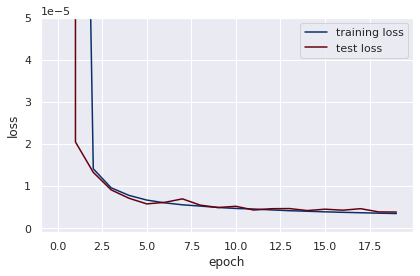

In [17]:
his = np.array(his)
cmap1 = cm.get_cmap('Blues')(np.linspace(1, 0.5, 3))
cmap2 = cm.get_cmap('Reds')(np.linspace(1, 0.5, 3))
fig, ax = plt.subplots(1, figsize = (6,4))
ax.plot(range(his.shape[0]), his[:,0], color=cmap1[0], label='training loss')
ax.plot(range(his.shape[0]), his[:,1], color=cmap2[0], label='test loss')
# ax.set_ylim([0,0.0001])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
ax.set_ylim([-1e-6,5e-5])
plt.tight_layout()
plt.show()

In [18]:
torch.save(model.state_dict(), 'temp_models/final_test_smooth_plus.pt')

In [19]:
torch.save(his, 'temp_models/final_test_smooth_plus.txt')

In [ ]:
path = 'temp_models/final_masked.pt'
model = Net().to(device)
model.load_state_dict(torch.load(path))
model.eval()

### Visualization

In [20]:
def display_temp_error(temp, data ,zoom=3.0,show_edges=False,
                        camera_position = [(200, 100, 100),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)],
                        camera_position_zoom = [(200/3, 100/3, 100/3),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)]):
    display = Display(visible=0)
    _ = display.start()
    output_show = temp
    range_ = [-0.1, 0.1]
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = np.array(output_show)
    elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if True]
    cells = np.array([item for sublist in elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(elements))
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temp'] = np.array(output_show)
    clipped = grid.clip('x', origin=(-2,0,0), invert=True)
    p = pv.Plotter(shape=(1, 1), window_size=([800, 300]),)
    p.camera_position = camera_position_zoom
    p.add_mesh(active_grid, show_edges=show_edges, scalars='temp',cmap="coolwarm",clim = range_)
    p.show()
    
def display_temp(temp, data, zoom=3.0, show_edges=False,
                        camera_position = [(200, 100, 100),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)],
                        camera_position_zoom = [(200/3, 100/3, 100/3),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)]):
    display = Display(visible=0)
    _ = display.start()
    output_show = temp
    range_ = [0, 1]
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = np.array(output_show)
    elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if True]
    cells = np.array([item for sublist in elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(elements))
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temp'] = np.array(output_show)
    clipped = grid.clip('x', origin=(-2,0,0), invert=True)
    p = pv.Plotter(shape=(1, 1), window_size=([800, 300]),)
    p.camera_position = camera_position_zoom
    p.add_mesh(active_grid, show_edges=show_edges, scalars='temp',cmap="coolwarm",clim = range_)
    p.show()

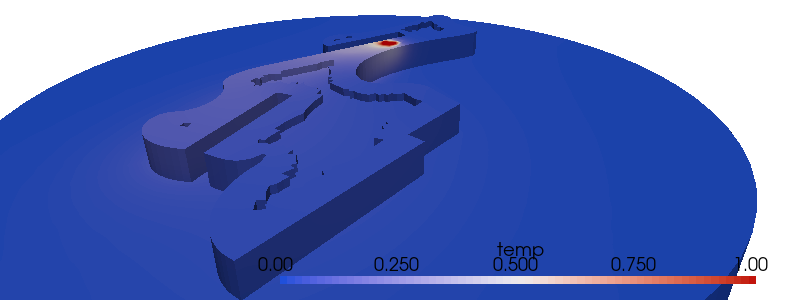

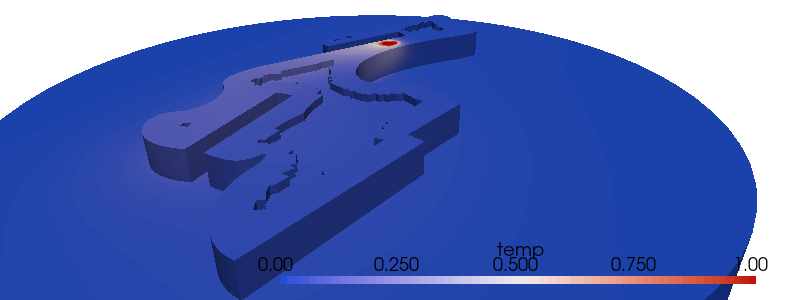

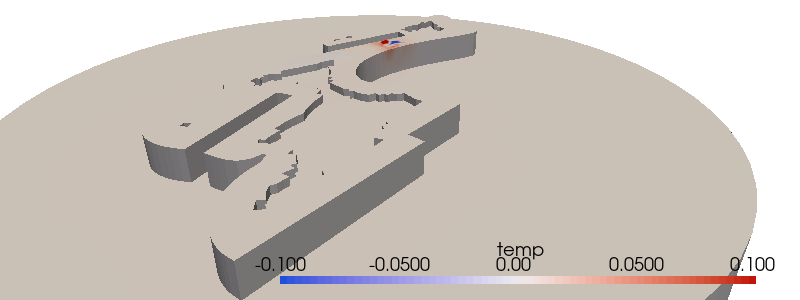

tensor(0.1834)
tensor(-0.2931)


In [21]:
# test_id = np.random.randint(0,len(dataset))
test_id = 10000
data = test_dataset[test_id]
data = data.to(device)
with torch.no_grad():
    prediction =  model(data).to("cpu")
data = data.to("cpu")
output = data.y
# stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
# output = output*(stats[3,3]-stats[3,2]) + stats[3,2]
# prediction = prediction*(stats[3,3]-stats[3,2]) + stats[3,2]
error = np.array(prediction - output)

display_temp(output,data)
display_temp(prediction,data)
display_temp_error(output-prediction,data)
err = prediction - output
print(err.max())
print(err.min())

### Recursive Prediction

### Single sample visualization

In [24]:
sample_num = 3
predictions = []
targets = []
for time_step in range(99):
    data = dataset[sample_num*99 + time_step]
    if time_step != 0:
        data.x = torch.cat((prediction,data.x[:,1:]), 1)
    target = data.y
    data = data.to(device)
    with torch.no_grad():
        prediction =  model(data).to("cpu")
    mask = data.x[:,1].reshape(-1,1)
#     prediction = prediction * mask.to("cpu")
    predictions.append(prediction)
    targets.append(target)
init_birth = dataset[sample_num*99].x[:,1]
birth = dataset[sample_num*99 + 98].x[:,1] - dataset[sample_num*99].x[:,1] 
predictions = torch.stack(predictions)[:,:,0] * 4700 + 300
targets = torch.stack(targets)[:,:,0] * 4700 + 300
error = torch.mean(torch.square(predictions - targets), dim = 1)

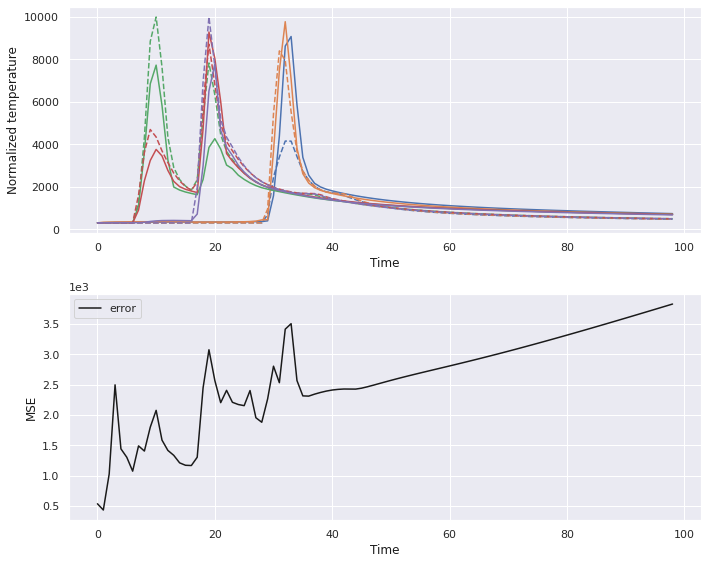

In [25]:
inds = np.where(birth.numpy()>0)[0][:5]
samples = len(inds)
# samples = 100
fig, axs = plt.subplots(2, 1, figsize=(10,8))
clrs = sns.color_palette(n_colors=samples)
# inds= torch.argsort(torch.square(predictions - targets)[98, :])[-5:]
# inds = np.random.randint(low = 0, high = predictions.shape[1], size=(samples))

x_range = list(range(99))
for i in range(samples):
    axs[0].plot(x_range, predictions[:, inds[i]], c=clrs[i])
    axs[0].plot(x_range, targets[:, inds[i]], '--', c=clrs[i])
axs[0].set_xlabel('Time', color='k')
axs[0].set_ylabel('Normalized temperature', color='k') 
# axs[0].legend()
axs[1].plot(x_range, error, label='error', c='k')
axs[1].set_xlabel('Time', color='k')
axs[1].set_ylabel('MSE', color='k')
axs[1].legend()
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()